In [1]:
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import scipy


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# parameters
n_grids = 350 # number of grid in grid search
R = 500 # number of Monte Carlo steps

def set_parameters(r1, r2):
    global N, M, const
    N = len(r1) # sample size of F
    M = len(r2) # sample size of G
    const = ((N*M/(N+M))**0.5)

def create_grids(r1, r2):
    global income
    _min = np.min([np.min(r1), np.min(r2)]) # find a common support for two incomes
    _max = np.max([np.max(r1), np.max(r2)])
    income = np.linspace(_min, _max, n_grids) # grids

def draw_random_multipliers():
    global U1_tensor, U2_tensor
    U1 = stats.norm.rvs(size=(N, R))/100
    U1_tensor = tf.constant(np.repeat(U1[None, ...], n_grids, 0)) # repeat for grid search dimension

    U2 = stats.norm.rvs(size=(M, R))/100
    U2_tensor = tf.constant(np.repeat(U2[None, ...], n_grids, 0)) # repeat for grid search dimension

def create_tensors(r1, r2):
    global N, M, income_N_tensor, income_M_tensor, r1_tensor, r2_tensor 
    income_N_tensor = np.repeat(income[..., None], N, 1) # repeat for sample dimension
    income_N_tensor = np.repeat(income_N_tensor[..., None], R, 2) # repeat for MC dimension
    # income_N_tensor[0,0,0] == income_N_tensor[0,1,0] is True 
    # income_N_tensor[0,0,0] == income_N_tensor[0,0,1] is True 

    income_M_tensor = np.repeat(income[..., None], M, 1)
    income_M_tensor = np.repeat(income_M_tensor[..., None], R, 2)

    r1_tensor = np.repeat(r1[None, ...], n_grids, 0) # repeat for grid search dimension
    r1_tensor = np.repeat(r1_tensor[..., None], R, 2) # repeat for MC dimension
    r1_tensor = tf.constant(r1_tensor)

    r2_tensor = np.repeat(r2[None, ...], n_grids, 0)
    r2_tensor = np.repeat(r2_tensor[..., None], R, 2)
    r2_tensor = tf.constant(r2_tensor)


In [3]:
# Simple Numpy operation for S_hat 
def empirical_I(z, x, j):
    # x: one observation of the sample
    return (x <= z)*(z-x)**(j-1)/np.math.factorial(j-1)

def I(z, X, j):
    # Whole sample
    N = len(X)
    return 1/N*np.sum((X <= z)*(z-X)**(j-1))/np.math.factorial(j-1)

# Compute S_hat for given incomes r1 and r2
def S_hat_fn(r1, r2, j):
    global const, income
    fn = lambda z: (I(z, r2, j) - I(z, r1, j))
    a = np.array([fn(i) for i in income])
    
    S_hat1 = const*np.max(a)
    S_hat2 = -const*np.min(a)
    return S_hat1, S_hat2


In [4]:
# Make functions for Numpy adapt for Tensorflow Tensor
def empirical_I_tf(z, x, j):
    # x: one observation of the sample
    return tf.cast((x <= z), tf.float64)*tf.math.add(z, -x)**(j-1)/np.math.factorial(j-1)

def I_tf(z, X, j, N):
    # Whole sample
    A = tf.cast((X <= z), tf.float64)*tf.math.add(z, -X)**(j-1)
    A = tf.math.reduce_sum(A, axis=1, keepdims=True)
    A = tf.repeat(A, N, axis=1)
    return ((1/N)*A/np.math.factorial(j-1)).numpy()

def S_bar_fn(j):
    global N, M, income_N_tensor, income_M_tensor, r1_tensor, r2_tensor 
    a = empirical_I_tf(income_N_tensor, r1_tensor, j)
    b = I_tf(income_N_tensor, r1_tensor, j, N)

    c = empirical_I_tf(income_M_tensor, r2_tensor, j)
    d = I_tf(income_M_tensor, r2_tensor, j, M)

    e = ((c-d)*U2_tensor) - ((a-b)*U1_tensor)
    f = tf.math.reduce_sum(e, axis=1)

    S_bar1 = const*tf.math.reduce_max(f, axis=0)
    S_bar2 = -const*tf.math.reduce_min(f, axis=0)
    return S_bar1, S_bar2

In [5]:
def make_decision(S_bar, S_hat):
    p = np.mean(S_bar > S_hat) 
    print('P-value =', p)

    if p < 0.10:
        print("Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2")
        return 1
    else:
        print("Cannot reject Null; r2 is domaining r1 OR r2==r1")
        return 0



In [6]:
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google.colab'

In [7]:
# import pickle
# with open('/content/drive/My Drive/00_IRTG1792/copula/Py_notebooks/v3_OOS_income.pickle', 'rb') as handle:
#     results = pickle.load(handle)

# Local
import pickle
with open('../Py_notebooks/v3_OOS_income.pickle', 'rb') as handle:
    results = pickle.load(handle)

0.9021504401844291 1.4168554251261236


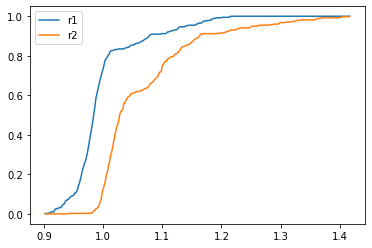

In [13]:
# two incomes
# r1 = (stats.t.rvs(df=10, size=350)*0.8)+3
# r2 = (stats.t.rvs(df=10, size=350)*1.2)+3.1

r1 = np.array(results[('t_Copula'), ('VaR q=0.05')])
r2 = np.array(results[('Frank'), ('VaR q=0.05')])
# r2 = np.array(results[('Gaussian'), ('VaR q=0.05')])


ecdf1 = ECDF(r1)
ecdf2 = ECDF(r2)

_min = np.min([np.min(r1), np.min(r2)]) # find a common support for two incomes
_max = np.max([np.max(r1), np.max(r2)])
x = np.linspace(_min, _max, n_grids) # grids
print(_min, _max)
plt.plot(x, ecdf1(x), label='r1')
plt.plot(x, ecdf2(x), label='r2')
plt.legend()

# test for SOSD
j = 1

In [9]:
try:
    del  N, M, income_N_tensor, income_M_tensor, r1_tensor, r2_tensor 
except: 
    pass

set_parameters(r1, r2)
create_grids(r1, r2)
S_hat1, S_hat2 = S_hat_fn(r1, r2, j)

draw_random_multipliers()
create_tensors(r1, r2)
S_bar1, S_bar2 = S_bar_fn(j)

Ha = make_decision(S_bar1, S_hat1)
Hb = make_decision(S_bar2, S_hat2)

# sns.distplot(S_bar)

P-value = 1.0
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.57
Cannot reject Null; r2 is domaining r1 OR r2==r1


In [10]:
def run(r1, r2, j):
    try:
        del  N, M, income_N_tensor, income_M_tensor, r1_tensor, r2_tensor 
    except: 
        pass

    set_parameters(r1, r2)
    create_grids(r1, r2)
    S_hat1, S_hat2 = S_hat_fn(r1, r2, j)

    draw_random_multipliers()
    create_tensors(r1, r2)
    S_bar1, S_bar2 = S_bar_fn(j)

    Ha = make_decision(S_bar1, S_hat1)
    Hb = make_decision(S_bar2, S_hat2)
    return Ha, Hb

In [11]:
run(r1,r2,2)

P-value = 0.904
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.322
Cannot reject Null; r2 is domaining r1 OR r2==r1


(0, 0)

In [14]:
CR_pairs = list(results.keys()) # All Copula and Risk meausre pairs

In [15]:
# DONT RUN THE SECOND TIME!
# print("Total number of operation is", len(CR_pairs)**2/2-len(CR_pairs))

# SOSD = np.ones([len(CR_pairs), len(CR_pairs)])+1000
# SOSD = pd.DataFrame(SOSD, index=CR_pairs, columns=CR_pairs)
# # save_file = '/content/drive/My Drive/00_IRTG1792/copula/Py_notebooks/SOSD.pickle'
# save_file = '../Py_notebooks/SOSD.pickle'

# for i, pair1 in enumerate(CR_pairs):
#     for k, pair2 in enumerate(CR_pairs):
#         if (k<i) or (k==i):
#             pass 
#         else:
#             r1 = np.array(results[pair1])
#             r2 = np.array(results[pair2])
#             SOSD.iloc[i,k], SOSD.iloc[k,i] = run(r1, r2, j=2)

#             if (k%5 == 0):
#                 with open(save_file, 'wb') as handle:
#                     pickle.dump(SOSD, handle)
#             print(i,k)
            
# with open(save_file, 'wb') as handle:
#     pickle.dump(SOSD, handle)

Total number of operation is 1104.0
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.888
Cannot reject Null; r2 is domaining r1 OR r2==r1
0 1
P-value = 0.372
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.86
Cannot reject Null; r2 is domaining r1 OR r2==r1
0 2
P-value = 0.89
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.494
Cannot reject Null; r2 is domaining r1 OR r2==r1
0 3
P-value = 0.902
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.036
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
0 4
P-value = 0.882
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.238
Cannot reject Null; r2 is domaining r1 OR r2==r1
0 5
P-value = 0.332
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.894
Cannot reject Null; r2 is domaining r1 OR r2==r1
0 6
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.9
Cannot reject Null; r2 is d

P-value = 0.898
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
1 11
P-value = 0.9
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
1 12
P-value = 0.256
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.53
Cannot reject Null; r2 is domaining r1 OR r2==r1
1 13
P-value = 0.904
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
1 14
P-value = 0.808
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.136
Cannot reject Null; r2 is domaining r1 OR r2==r1
1 15
P-value = 0.916
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
1 16
P-value = 0.904
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (cross

P-value = 0.042
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.872
Cannot reject Null; r2 is domaining r1 OR r2==r1
2 21
P-value = 0.916
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
2 22
P-value = 0.066
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.902
Cannot reject Null; r2 is domaining r1 OR r2==r1
2 23
P-value = 0.896
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.006
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
2 24
P-value = 0.02
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.882
Cannot reject Null; r2 is domaining r1 OR r2==r1
2 25
P-value = 0.878
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.014
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
2 26
P-value = 0.34
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value =

P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.878
Cannot reject Null; r2 is domaining r1 OR r2==r1
3 33
P-value = 0.932
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.002
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
3 34
P-value = 0.654
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.372
Cannot reject Null; r2 is domaining r1 OR r2==r1
3 35
P-value = 0.658
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.588
Cannot reject Null; r2 is domaining r1 OR r2==r1
3 36
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.884
Cannot reject Null; r2 is domaining r1 OR r2==r1
3 37
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.876
Cannot reject Null; r2 is domaining r1 OR r2==r1
3 38
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.884
Cannot reject Nul

P-value = 0.076
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.88
Cannot reject Null; r2 is domaining r1 OR r2==r1
4 46
P-value = 0.03
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.904
Cannot reject Null; r2 is domaining r1 OR r2==r1
4 47
P-value = 0.094
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.88
Cannot reject Null; r2 is domaining r1 OR r2==r1
5 6
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.89
Cannot reject Null; r2 is domaining r1 OR r2==r1
5 7
P-value = 0.002
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.888
Cannot reject Null; r2 is domaining r1 OR r2==r1
5 8
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.864
Cannot reject Null; r2 is domaining r1 OR r2==r1
5 9
P-value = 0.774
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.16
Ca

P-value = 0.002
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.868
Cannot reject Null; r2 is domaining r1 OR r2==r1
6 19
P-value = 0.102
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.758
Cannot reject Null; r2 is domaining r1 OR r2==r1
6 20
P-value = 0.044
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.88
Cannot reject Null; r2 is domaining r1 OR r2==r1
6 21
P-value = 0.896
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
6 22
P-value = 0.088
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.892
Cannot reject Null; r2 is domaining r1 OR r2==r1
6 23
P-value = 0.868
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.018
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
6 24
P-value = 0.038
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value 

P-value = 0.93
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
7 34
P-value = 0.902
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
7 35
P-value = 0.892
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
7 36
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.882
Cannot reject Null; r2 is domaining r1 OR r2==r1
7 37
P-value = 0.866
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
7 38
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.858
Cannot reject Null; r2 is domaining r1 OR r2==r1
7 39
P-value = 0.91
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Rejec

P-value = 0.878
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
9 12
P-value = 0.406
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.218
Cannot reject Null; r2 is domaining r1 OR r2==r1
9 13
P-value = 0.902
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
9 14
P-value = 0.88
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.028
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
9 15
P-value = 0.912
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
9 16
P-value = 0.882
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
9 17
P-value = 0.216
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.218
Cannot reject Null

P-value = 0.12
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.868
Cannot reject Null; r2 is domaining r1 OR r2==r1
10 30
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.91
Cannot reject Null; r2 is domaining r1 OR r2==r1
10 31
P-value = 0.008
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.878
Cannot reject Null; r2 is domaining r1 OR r2==r1
10 32
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.918
Cannot reject Null; r2 is domaining r1 OR r2==r1
10 33
P-value = 0.882
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.178
Cannot reject Null; r2 is domaining r1 OR r2==r1
10 34
P-value = 0.136
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.898
Cannot reject Null; r2 is domaining r1 OR r2==r1
10 35
P-value = 0.098
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.872
Cannot reject Null; r2 is dom

P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.89
Cannot reject Null; r2 is domaining r1 OR r2==r1
12 15
P-value = 0.892
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.08
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
12 16
P-value = 0.198
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.818
Cannot reject Null; r2 is domaining r1 OR r2==r1
12 17
P-value = 0.03
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.914
Cannot reject Null; r2 is domaining r1 OR r2==r1
12 18
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.882
Cannot reject Null; r2 is domaining r1 OR r2==r1
12 19
P-value = 0.042
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.894
Cannot reject Null; r2 is domaining r1 OR r2==r1
12 20
P-value = 0.03
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value

P-value = 0.91
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
13 36
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.9
Cannot reject Null; r2 is domaining r1 OR r2==r1
13 37
P-value = 0.856
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.186
Cannot reject Null; r2 is domaining r1 OR r2==r1
13 38
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.876
Cannot reject Null; r2 is domaining r1 OR r2==r1
13 39
P-value = 0.906
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
13 40
P-value = 0.894
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.008
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
13 41
P-value = 0.91
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 i

P-value = 0.896
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.008
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
15 27
P-value = 0.902
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
15 28
P-value = 0.924
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
15 29
P-value = 0.882
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
15 30
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.89
Cannot reject Null; r2 is domaining r1 OR r2==r1
15 31
P-value = 0.866
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.008
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
15 32
P-value = 0.378
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value 

P-value = 0.056
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.89
Cannot reject Null; r2 is domaining r1 OR r2==r1
17 20
P-value = 0.014
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.902
Cannot reject Null; r2 is domaining r1 OR r2==r1
17 21
P-value = 0.896
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
17 22
P-value = 0.03
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.89
Cannot reject Null; r2 is domaining r1 OR r2==r1
17 23
P-value = 0.87
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.268
Cannot reject Null; r2 is domaining r1 OR r2==r1
17 24
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.876
Cannot reject Null; r2 is domaining r1 OR r2==r1
17 25
P-value = 0.348
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.236
Cannot reje

P-value = 0.9
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.088
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
18 47
P-value = 0.66
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.156
Cannot reject Null; r2 is domaining r1 OR r2==r1
19 20
P-value = 0.738
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.236
Cannot reject Null; r2 is domaining r1 OR r2==r1
19 21
P-value = 0.89
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
19 22
P-value = 0.856
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.166
Cannot reject Null; r2 is domaining r1 OR r2==r1
19 23
P-value = 0.86
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
19 24
P-value = 0.898
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.004
Reject Null; r2 is not domaining r1 (crossing) OR r1

P-value = 0.886
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.11
Cannot reject Null; r2 is domaining r1 OR r2==r1
20 47
P-value = 0.898
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.002
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
21 22
P-value = 0.89
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.404
Cannot reject Null; r2 is domaining r1 OR r2==r1
21 23
P-value = 0.902
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.014
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
21 24
P-value = 0.692
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.068
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
21 25
P-value = 0.874
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.014
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
21 26
P-value = 0.866
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.036
Reject Null; r2 is not do

P-value = 0.892
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.012
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
23 26
P-value = 0.886
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.07
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
23 27
P-value = 0.898
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.012
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
23 28
P-value = 0.886
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.036
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
23 29
P-value = 0.902
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.074
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
23 30
P-value = 0.04
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.456
Cannot reject Null; r2 is domaining r1 OR r2==r1
23 31
P-value = 0.694
Cannot reject Null; r2 is domaining r1 OR r2==r1
P

P-value = 0.852
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.004
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
25 36
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.856
Cannot reject Null; r2 is domaining r1 OR r2==r1
25 37
P-value = 0.138
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.886
Cannot reject Null; r2 is domaining r1 OR r2==r1
25 38
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.86
Cannot reject Null; r2 is domaining r1 OR r2==r1
25 39
P-value = 0.91
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
25 40
P-value = 0.69
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.022
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
25 41
P-value = 0.884
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.004
Reject Null;

P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.9
Cannot reject Null; r2 is domaining r1 OR r2==r1
28 31
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.894
Cannot reject Null; r2 is domaining r1 OR r2==r1
28 32
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.902
Cannot reject Null; r2 is domaining r1 OR r2==r1
28 33
P-value = 0.316
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.898
Cannot reject Null; r2 is domaining r1 OR r2==r1
28 34
P-value = 0.006
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.9
Cannot reject Null; r2 is domaining r1 OR r2==r1
28 35
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.91
Cannot reject Null; r2 is domaining r1 OR r2==r1
28 36
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.89

P-value = 0.906
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
31 35
P-value = 0.878
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
31 36
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.862
Cannot reject Null; r2 is domaining r1 OR r2==r1
31 37
P-value = 0.884
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
31 38
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.884
Cannot reject Null; r2 is domaining r1 OR r2==r1
31 39
P-value = 0.894
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
31 40
P-value = 0.904
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0

P-value = 0.006
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.878
Cannot reject Null; r2 is domaining r1 OR r2==r1
34 47
P-value = 0.49
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.692
Cannot reject Null; r2 is domaining r1 OR r2==r1
35 36
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.88
Cannot reject Null; r2 is domaining r1 OR r2==r1
35 37
P-value = 0.008
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.908
Cannot reject Null; r2 is domaining r1 OR r2==r1
35 38
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.904
Cannot reject Null; r2 is domaining r1 OR r2==r1
35 39
P-value = 0.866
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.142
Cannot reject Null; r2 is domaining r1 OR r2==r1
35 40
P-value = 0.276
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.88
Cannot reject Null; r2 is doma

P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.906
Cannot reject Null; r2 is domaining r1 OR r2==r1
40 45
P-value = 0.1
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.884
Cannot reject Null; r2 is domaining r1 OR r2==r1
40 46
P-value = 0.044
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.89
Cannot reject Null; r2 is domaining r1 OR r2==r1
40 47
P-value = 0.876
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.338
Cannot reject Null; r2 is domaining r1 OR r2==r1
41 42
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.862
Cannot reject Null; r2 is domaining r1 OR r2==r1
41 43
P-value = 0.038
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.9
Cannot reject Null; r2 is domaining r1 OR r2==r1
41 44
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
P-value = 0.91
Cannot reject N

In [33]:
with open(save_file, 'wb') as handle:
    pickle.dump(SOSD, handle)

0.8755050911574485 1.1242429199677781


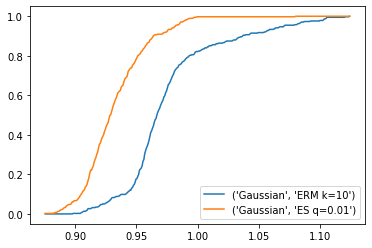

In [168]:
r1 = results[CR_pairs[0]]
r2 = results[CR_pairs[1]]
ecdf1 = ECDF(r1)
ecdf2 = ECDF(r2)

_min = np.min([np.min(r1), np.min(r2)]) # find a common support for two incomes
_max = np.max([np.max(r1), np.max(r2)])
x = np.linspace(_min, _max, n_grids) # grids
print(_min, _max)
plt.plot(x, ecdf1(x), label=CR_pairs[0])
plt.plot(x, ecdf2(x), label=CR_pairs[1])
plt.legend()

In [17]:
pair1 = "(Frank, Variance)"

C1 = pair1[1:pair1.find(', ')]
R1 = pair1[pair1.find(', ')+2:-1]
pair1 = (C1, R1)

r1 = np.array(results[pair1])
r2 = np.ones(len(r1))
run(r1, r2, j=2)

P-value = 0.842
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.008
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2


(0, 1)

In [26]:
Ha_arr = []
Hb_arr = []

for i, pair1 in enumerate(CR_pairs):
    r1 = np.array(results[pair1])
    r2 = np.ones(len(r1))
    Ha, Hb = (run(r1, r2, j=2))
    Ha_arr.append(Ha)
    Hb_arr.append(Hb)
    print(pair1, Ha, Hb)

P-value = 0.856
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
('Gaussian', 'ERM k=10') 0 1
P-value = 0.868
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
('Gaussian', 'ES q=0.01') 0 1
P-value = 0.872
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
('Gaussian', 'ES q=0.05') 0 1
P-value = 0.882
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
('Gaussian', 'VaR q=0.01') 0 1
P-value = 0.342
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.086
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
('Gaussian', 'VaR q=0.05') 0 1
P-value = 0.852
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domai

P-value = 0.9
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.002
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
('NIG_factor', 'VaR q=0.05') 0 1
P-value = 0.892
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.0
Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2
('NIG_factor', 'Variance') 0 1


In [35]:
SOSD.loc['target', :] = Hb_arr + [1001]

In [36]:
SOSD.loc[:, 'target'] = Ha_arr + [1001]

In [37]:
SOSD

(Gaussian, ERM k=10)  (Gaussian, ES q=0.01)  \
(Gaussian, ERM k=10)                         1001.0                    1.0   
(Gaussian, ES q=0.01)                           0.0                 1001.0   
(Gaussian, ES q=0.05)                           0.0                    1.0   
(Gaussian, VaR q=0.01)                          0.0                    1.0   
(Gaussian, VaR q=0.05)                          1.0                    1.0   
(Gaussian, Variance)                            0.0                    1.0   
(t_Copula, ERM k=10)                            0.0                    1.0   
(t_Copula, ES q=0.01)                           0.0                    0.0   
(t_Copula, ES q=0.05)                           0.0                    1.0   
(t_Copula, VaR q=0.01)                          0.0                    0.0   
(t_Copula, VaR q=0.05)                          1.0                    1.0   
(t_Copula, Variance)                            0.0                    1.0   
(Clayton, ERM k=10)                             1.0                    1.0   
(Clayton, ES q=0.01)                            0.0                    0.0   
(Clayton, ES q=0.05)                            0.0                    1.0   
(Clayton, VaR q=0.01)                           0.0                    0.0   
(Clayton, VaR q=0.05)                           1.0                    1.0   
(Clayton, Variance)                             0.0                    1.0   
(Frank, ERM k=10)                               0.0                    0.0   
(Frank, ES q=0.01)                              0.0                    0.0   
(Frank, ES q=0.05)                              0.0                    0.0   
(Frank, VaR q=0.01)                             0.0                    0.0   
(Frank, VaR q=0.05)                             1.0                    1.0   
(Frank, Variance)                               0.0                    0.0   
(Gumbel, ERM k=10)                              1.0                    1.0   
(Gumbel, ES q=0.01)                             0.0                    1.0   
(Gumbel, ES q=0.05)                             1.0                    1.0   
(Gumbel, VaR q=0.01)                            0.0                    1.0   
(Gumbel, VaR q=0.05)                            1.0                    1.0   
(Gumbel, Variance)                              0.0                    1.0   
(Plackett, ERM k=10)                            0.0                    1.0   
(Plackett, ES q=0.01)                           0.0                    0.0   
(Plackett, ES q=0.05)                           0.0                    1.0   
(Plackett, VaR q=0.01)                          0.0                    0.0   
(Plackett, VaR q=0.05)                          1.0                    1.0   
(Plackett, Variance)                            0.0                    1.0   
(Gauss Mix Indep, ERM k=10)                     0.0                    1.0   
(Gauss Mix Indep, ES q=0.01)                    0.0                    0.0   
(Gauss Mix Indep, ES q=0.05)                    0.0                    1.0   
(Gauss Mix Indep, VaR q=0.01)                   0.0                    0.0   
(Gauss Mix Indep, VaR q=0.05)                   1.0                    1.0   
(Gauss Mix Indep, Variance)                     0.0                    1.0   
(NIG_factor, ERM k=10)                          0.0                    1.0   
(NIG_factor, ES q=0.01)                         0.0                    0.0   
(NIG_factor, ES q=0.05)                         0.0                    1.0   
(NIG_factor, VaR q=0.01)                        0.0                    0.0   
(NIG_factor, VaR q=0.05)                        0.0                    1.0   
(NIG_factor, Variance)                          0.0                    1.0   
target                                          1.0                    1.0   

                               (Gaussian, ES q=0.05)  (Gaussian, VaR q=0.01)  \
(Gaussian, ERM k=10)                             0

In [38]:
with open(save_file, 'wb') as handle:
    pickle.dump(SOSD, handle)

In [41]:
[(Ha_arr[i], Hb_arr[i]) for i in range(len(Ha_arr))]

[(0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (1, 0),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (1, 0),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (1, 0),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 0),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1)]